# **Лабораторная работа 1**
# Фильтр Байеса


### Задача

В начале помещения находится мобильный робот с координатой 0 в помещении длиной SIZE.  Робот перемещается вдоль одного направления по ячейкам шириной 1 метр. Исполнительные механизмы робота неидеальны, а также присутствует проскальзывание. Вследствие этого, робот перемещеается в заданную ячейку с вероятностью 40%, в соседнюю с ней - с вероятностью 20%, через одну от нее - 10%. Гистограмма погрешности приведена ниже.

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import random
from scipy.stats import norm

seed = 50
random.seed(seed)
np.random.seed(seed)

<BarContainer object of 5 artists>

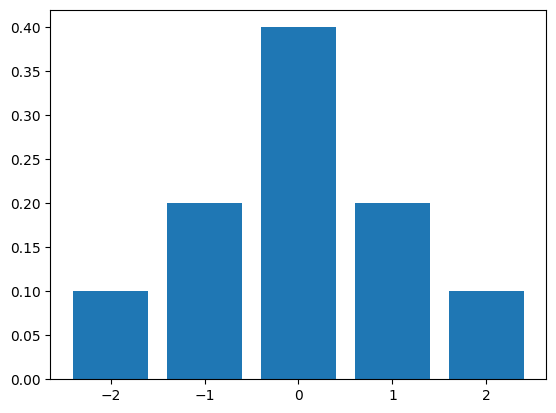

In [24]:
robot_errors = [-2, -1, 0, 1, 2]
robot_prob = [0.1, 0.2, 0.4, 0.2, 0.1]
plt.bar(robot_errors, robot_prob)

Положение робота измеряется датчиком с нормальным распределением погрешности, математическое ожидание которой соотвествует положению робота. Рапределение погрешности датчика приведено ниже.

In [25]:
N = 100
sigma = 3
mu = 0
x = np.linspace(-10, +10, N)
p = (2 * np.pi * (sigma ** 2)) ** (-0.5) * np.exp(-0.5 * np.power( x - mu, 2)/ (sigma ** 2))

Робот выполняет перемещение в произвольно заданную ячейку $N$. После чего измеряет положение датчиком и применяет фильтр Байеса для уточнения своего положения (данные положения робот может запрашивать сколько потребуется раз). 

### **Задание**
Требуется:

- Написать программный код, иммитирующий изменение распределения плотности вероятности нахождения робота в ячейках при перемещении (допускается, что робот перемещается в центр ячейки).
- Реализовать функцию, иммитируюущую измерение положения робота датчиком.
- Написать функцию, реализующую фильтр Байеса для определения положения робота.
- Построить график зависимости максимальной вероятности нахождения робота в ячейке от количества измерений.
- Построить график распределения плотности вероятности положения робота после многократных измерений.
- Повторить два предыдущих пункта для трех перемещений при различных среднеквадратических отклонениях показаний датчика.

In [26]:
size = 25
search_area = np.arange(size + 1) # от 0 до 25 метров включительно
coord_min = search_area[0]  # границы
coord_max = search_area[-1]

#### Часть 1. Написать программный код, иммитирующий изменение распределения плотности вероятности нахождения робота в ячейках при перемещении (допускается, что робот перемещается в центр ячейки).

In [27]:
def movement_of_robot(pose):
    random = np.random.rand(1)
    if random < 0.1:
        true_pose = pose - 2
    elif random >= 0.1 and random < 0.3:
        true_pose = pose - 1
    elif random >= 0.7 and random < 0.9:
        true_pose = pose + 1
    elif random >= 0.9:
        true_pose = pose + 2
    else:
        true_pose = pose

    return true_pose

In [28]:
desired_position = 20
real_position = movement_of_robot(pose=desired_position)
print(f'Желаемая позиция {desired_position} метров \nРеальная позиция {real_position} метров')

Желаемая позиция 20 метров 
Реальная позиция 20 метров


<BarContainer object of 5 artists>

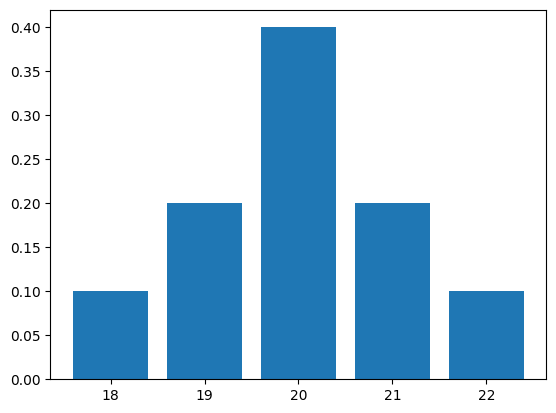

In [29]:
# Гистограмма вероятностей нахождения в точках карты
probable_position = np.array([-2, -1, 0, 1, 2]) + desired_position
robot_prob = [0.1, 0.2, 0.4, 0.2, 0.1]
plt.bar(probable_position, robot_prob)

In [30]:
f_prior = np.zeros(len(search_area))  # создадим массив из 0, а дальше учтём наше распределение вероятности нахождения в районе желаемой позиции
f_prior[desired_position - 2], f_prior[desired_position - 1] = 0.1, 0.2
f_prior[desired_position + 2], f_prior[desired_position + 1] = 0.1, 0.2
f_prior[desired_position] = 0.4
f_prior

array([0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0.1, 0.2, 0.4, 0.2, 0.1, 0. , 0. , 0. ])

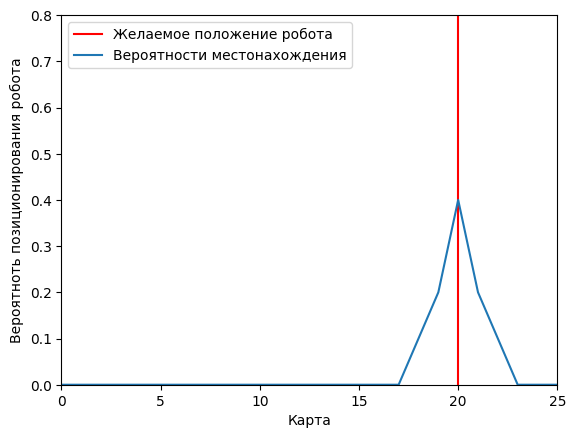

In [31]:
fig, ax = plt.subplots()
ax.plot([desired_position, desired_position], [0, 1],  c='red', alpha=1, label = "Желаемое положение робота")
ax.plot(search_area, f_prior, label = "Вероятности местонахождения")
ax.set(xlim=(coord_min, coord_max), ylim=(0, 2 * np.max(f_prior)))
ax.set_xlabel("Карта")
ax.set_ylabel("Вероятноть позиционирования робота")
ax.legend()
plt.show()

#### Часть 2. Реализовать функцию, иммитируюущую измерение положения робота датчиком.

Text(0.5, 1.0, 'График априорного распределения положения робота для желаемой позиции')

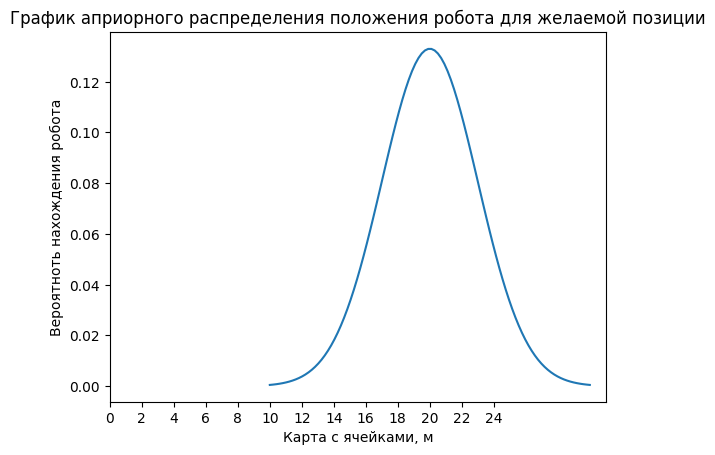

In [32]:
def sens_pos_def(mu=0, sigma=3, N=100):
  x = np.linspace(mu-10, mu+10, N)
  p = (2 * np.pi * (sigma ** 2)) ** (-0.5) * np.exp(-0.5 * np.power( x - mu, 2)/ (sigma ** 2))
  return p, x

sens_pos, x = sens_pos_def(mu=real_position)  # задали реальное положение и с помощью функции для измерений датчика получили распределение для положения робота
fig, ax = plt.subplots()
plt.plot(x, sens_pos)
ax.set_xlabel("Карта с ячейками, м")
ax.xaxis.set_ticks(np.arange(coord_min, coord_max, step=2))  # шаг по оси оХ
ax.set_ylabel("Вероятноть нахождения робота")
plt.title('График априорного распределения положения робота для желаемой позиции')

[(0.0, 25.0),
 Text(0.5, 1.0, 'Гистограмма измерения положения робота датчиком')]

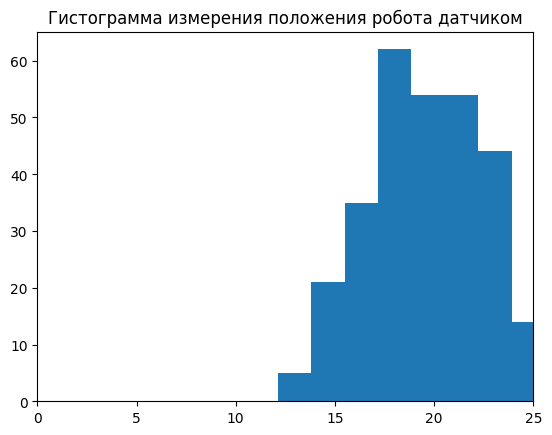

In [33]:
N = 300  # число измерений
sigma = 3 # дисперсия
sens_pos = sigma * np.random.randn(N) + real_position  # генерируем вектор гипотез (замеров) местонахождения

fig, ax = plt.subplots()

ax.hist(sens_pos)
ax.set(xlim=(coord_min, coord_max), title='Гистограмма измерения положения робота датчиком')

#### Часть 3. Написать функцию, реализующую фильтр Байеса для определения положения робота.

In [34]:
from scipy.stats import norm

def bayes_formula(prior, y):
    numerator = []
    for i in range(len(search_area)):
        numerator.append(prior[i] * norm.pdf(x=y, loc=search_area[i], scale=sigma))
    return numerator/np.sum(numerator)

In [35]:
f_posteriors = [f_prior]  # Список функций плотностей распределения от опыта к опыту

for measurement in sens_pos:
  f_prior = f_posteriors[len(f_posteriors) - 1]
  # Вычисление уточненного распределения
  f_posterior = bayes_formula(prior=f_prior, y=measurement)
  
  f_posteriors.append(f_posterior)

#### Часть 4. Построить график зависимости максимальной вероятности нахождения робота в ячейке от количества измерений.

MovieWriter matplotlib.animation.PillowWriter unavailable; using Pillow instead.


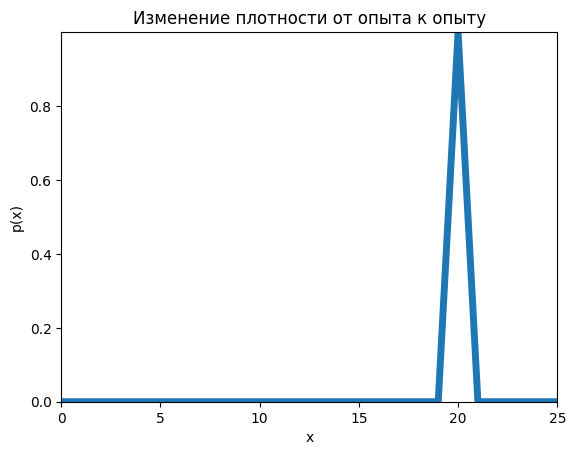

In [36]:
%matplotlib inline

from matplotlib.animation import FuncAnimation
fig, ax = plt.subplots()                    
ax.set(xlim=(coord_min, coord_max), ylim=(0, np.max(f_posteriors)), title='Изменение плотности от опыта к опыту')
ax.set_xlabel("x")
ax.set_ylabel("p(x)")
line, = ax.plot([], [], lw=5)

def init():
    line.set_data([], [])
    return line,

def animate(i):
    line.set_data(search_area, f_posteriors[i])
    return line,

anim = FuncAnimation(fig, animate, init_func=init, frames=N, interval=80, blit=True)
anim.save('posteriors.gif', writer='matplotlib.animation.PillowWriter')

Text(0.5, 1.0, 'Вероятность нахождения робота в ячейке от количества измерений')

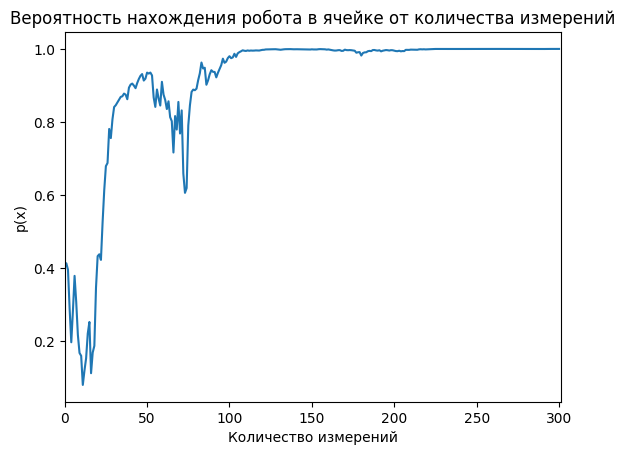

In [37]:
# Вероятность нахождения робота в ячейке от кол-ва измерений
probability = []
for i in range(len(f_posteriors)):
  probability.append(f_posteriors[i][real_position]) 

x = range(len(f_posteriors)) 

plt.plot(x, probability)
plt.xlabel('Количество измерений')
plt.ylabel('p(x)')
plt.xlim(0, len(f_posteriors))
plt.title('Вероятность нахождения робота в ячейке от количества измерений')

#### Часть 5. Построить график распределения плотности вероятности положения робота после многократных измерений.

Желаемая позиция 7 метров 
Реальная позиция 7 метров


<BarContainer object of 5 artists>

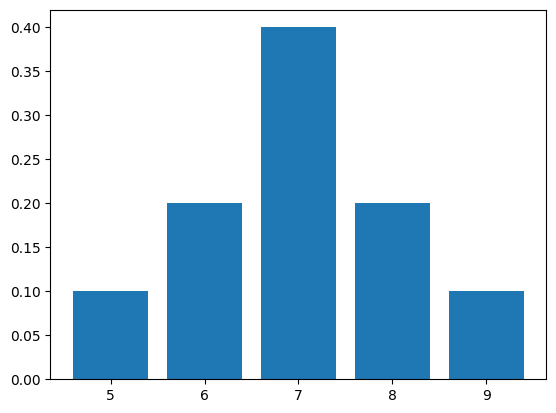

In [38]:
desired_position = 7
real_position = movement_of_robot(pose=desired_position)
print(f'Желаемая позиция {desired_position} метров \nРеальная позиция {real_position} метров')

probable_position = np.array([-2, -1, 0, 1, 2]) + desired_position
robot_prob = [0.1, 0.2, 0.4, 0.2, 0.1]
plt.bar(probable_position, robot_prob)

Text(0.5, 1.0, 'График априорного распределения положения робота для желаемой позиции')

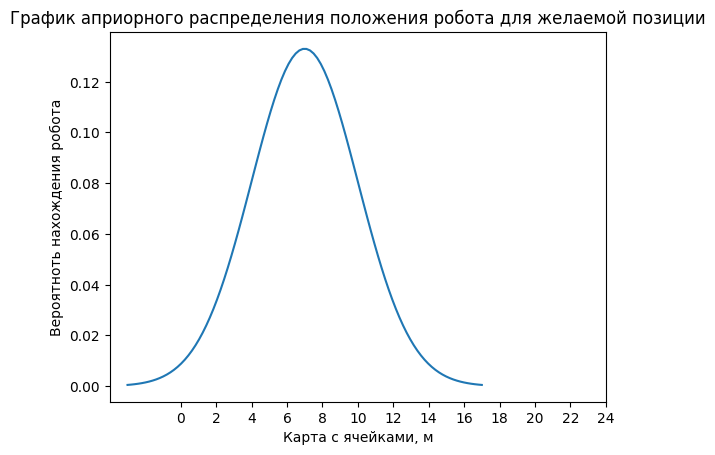

In [39]:
f_prior = np.zeros(len(search_area))  # создадим массив из 0, а дальше учтём наше распределение вероятности нахождения в районе желаемой позиции
f_prior[desired_position - 2], f_prior[desired_position - 1] = 0.1, 0.2
f_prior[desired_position + 2], f_prior[desired_position + 1] = 0.1, 0.2
f_prior[desired_position] = 0.4
f_prior

sens_pos, x = sens_pos_def(mu=real_position)
fig, ax = plt.subplots()
plt.plot(x, sens_pos)
ax.set_xlabel("Карта с ячейками, м")
ax.xaxis.set_ticks(np.arange(coord_min, coord_max, step=2))
ax.set_ylabel("Вероятноть нахождения робота")
plt.title('График априорного распределения положения робота для желаемой позиции')

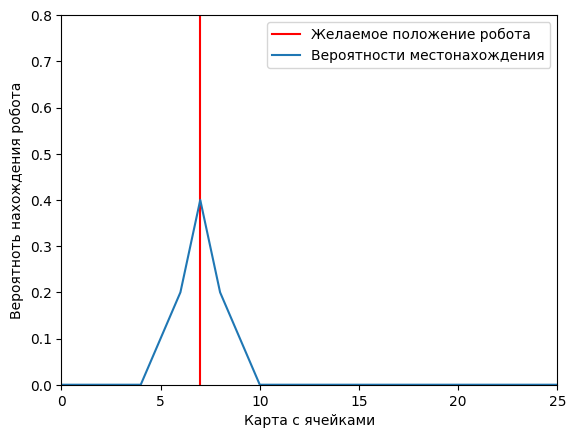

In [40]:
fig, ax = plt.subplots()
ax.plot([desired_position, desired_position], [0, 1],  c='red', alpha=1, label = "Желаемое положение робота")
ax.plot(search_area, f_prior, label = "Вероятности местонахождения")

ax.set(xlim=(coord_min, coord_max), ylim=(0, 2 * np.max(f_prior)))
ax.set_xlabel("Карта с ячейками")
ax.set_ylabel("Вероятноть нахождения робота")
ax.legend()
plt.show()

[(0.0, 25.0),
 Text(0.5, 1.0, 'Гистограмма измерения положения робота датчиком')]

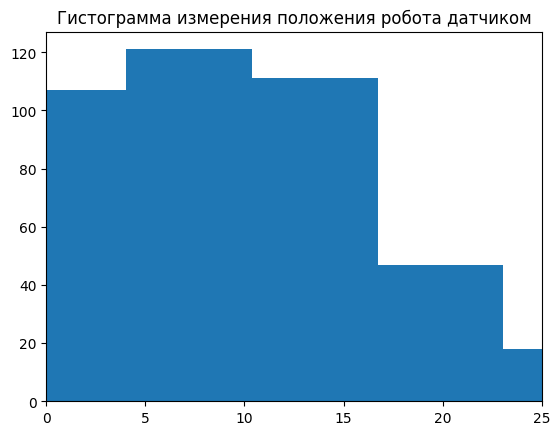

In [41]:
N = 500  # число измерений
sigma = 10 # дисперсия
sens_pos = sigma * np.random.randn(N) + real_position

fig, ax = plt.subplots()

ax.hist(sens_pos)
ax.set(xlim=(coord_min, coord_max), title='Гистограмма измерения положения робота датчиком')

MovieWriter matplotlib.animation.PillowWriter unavailable; using Pillow instead.


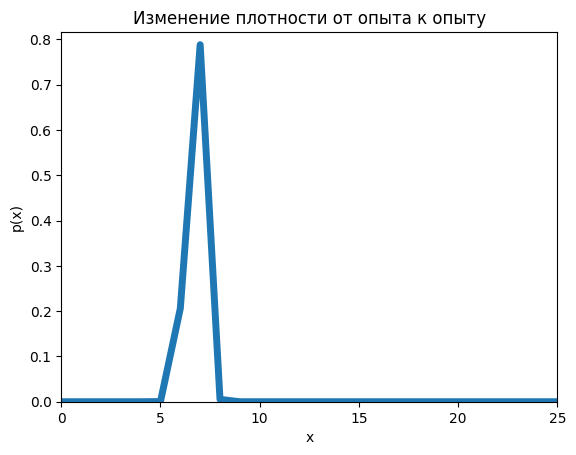

In [42]:
f_posteriors = [f_prior]  # Список функций плотностей распределения от опыта к опыту

for measurement in sens_pos:
  f_prior = f_posteriors[len(f_posteriors) - 1]
  f_posterior = bayes_formula(prior=f_prior, y=measurement)
  f_posteriors.append(f_posterior)

%matplotlib inline

from matplotlib.animation import FuncAnimation
fig, ax = plt.subplots()                    
ax.set(xlim=(coord_min, coord_max), ylim=(0, np.max(f_posteriors)), title='Изменение плотности от опыта к опыту')
ax.set_xlabel("x")
ax.set_ylabel("p(x)")

line, = ax.plot([], [], lw=5)

def init():
    line.set_data([], [])
    return line,

def animate(i):
    line.set_data(search_area, f_posteriors[i])
    return line,

anim = FuncAnimation(fig, animate, init_func=init, frames=N, interval=80, blit=True)
anim.save('posteriors1.gif', writer='matplotlib.animation.PillowWriter')

Text(0.5, 1.0, 'Зависимость максимальной вероятности нахождения робота в ячейке от количества измерений')

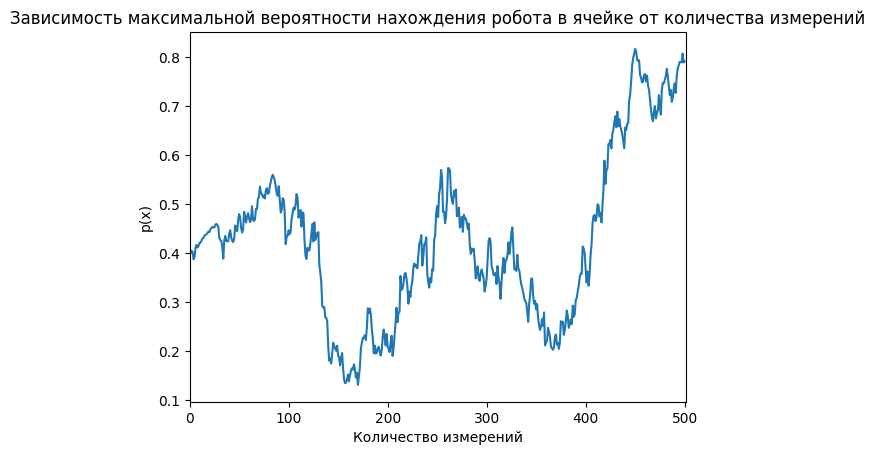

In [43]:
probability1 = []
for i in range(len(f_posteriors)):
  probability1.append(f_posteriors[i][real_position])

x = range(len(f_posteriors)) 

plt.plot(x, probability1)
plt.xlabel('Количество измерений')
plt.ylabel('p(x)')
plt.xlim(0, len(f_posteriors))
plt.title('Зависимость максимальной вероятности нахождения робота в ячейке от количества измерений')

#### 6. Повторить два предыдущих пункта для трех перемещений при различных среднеквадратических отклонениях показаний датчика.

Желаемая позиция 19 метров 
Реальная позиция 19 метров


<BarContainer object of 5 artists>

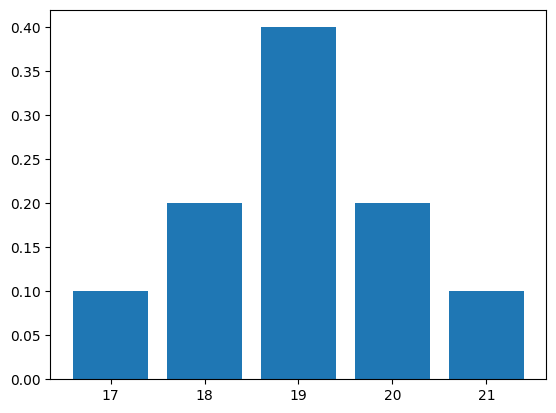

In [44]:
desired_position = 19
real_position = movement_of_robot(pose=desired_position)
print(f'Желаемая позиция {desired_position} метров \nРеальная позиция {real_position} метров')

probable_position = np.array([-2, -1, 0, 1, 2]) + desired_position
robot_prob = [0.1, 0.2, 0.4, 0.2, 0.1]
plt.bar(probable_position, robot_prob)

Text(0.5, 1.0, 'График априорного распределения положения робота для желаемой позиции')

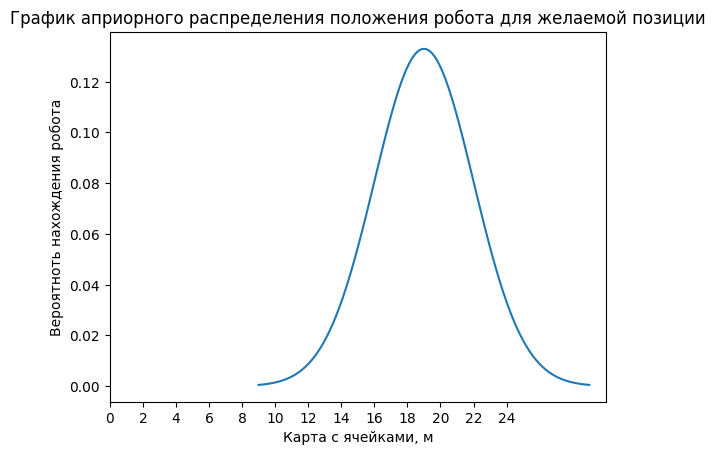

In [45]:
f_prior = np.zeros(len(search_area))  # создадим массив из 0, а дальше учтём наше распределение вероятности нахождения в районе желаемой позиции
f_prior[desired_position - 2], f_prior[desired_position - 1] = 0.1, 0.2
f_prior[desired_position + 2], f_prior[desired_position + 1] = 0.1, 0.2
f_prior[desired_position] = 0.4
f_prior

sens_pos, x = sens_pos_def(mu=real_position)
fig, ax = plt.subplots()
plt.plot(x, sens_pos)
ax.set_xlabel("Карта с ячейками, м")
ax.xaxis.set_ticks(np.arange(coord_min, coord_max, step=2))
ax.set_ylabel("Вероятноть нахождения робота")
plt.title('График априорного распределения положения робота для желаемой позиции')

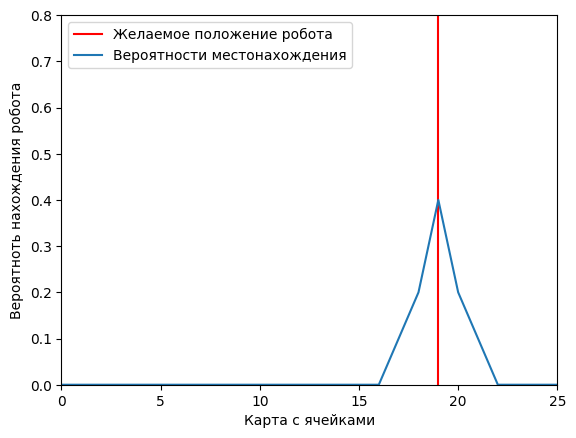

In [46]:
fig, ax = plt.subplots()
ax.plot([desired_position, desired_position], [0, 1],  c='red', alpha=1, label = "Желаемое положение робота")
ax.plot(search_area, f_prior, label = "Вероятности местонахождения")

ax.set(xlim=(coord_min, coord_max), ylim=(0, 2 * np.max(f_prior)))
ax.set_xlabel("Карта с ячейками")
ax.set_ylabel("Вероятноть нахождения робота")
ax.legend()
plt.show()

[(0.0, 25.0),
 Text(0.5, 1.0, 'Гистограмма измерения положения робота датчиком')]

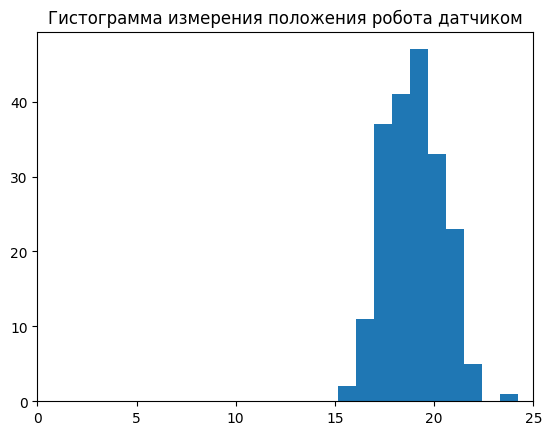

In [47]:
N = 200  # число измерений
sigma = 1.3 # дисперсия
sens_pos = sigma * np.random.randn(N) + real_position

fig, ax = plt.subplots()

ax.hist(sens_pos)
ax.set(xlim=(coord_min, coord_max), title='Гистограмма измерения положения робота датчиком')

MovieWriter matplotlib.animation.PillowWriter unavailable; using Pillow instead.


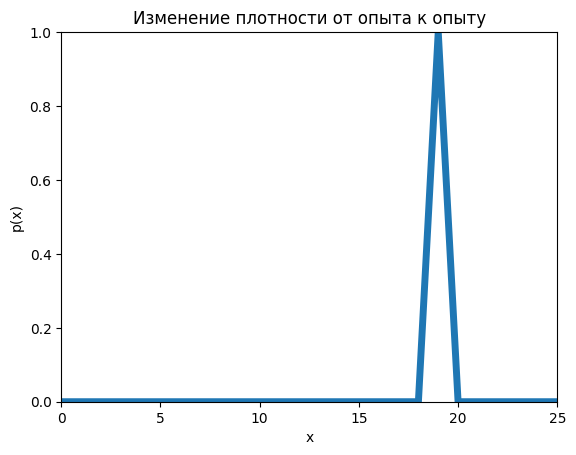

In [48]:
f_posteriors = [f_prior]  # Список функций плотностей распределения от опыта к опыту

for measurement in sens_pos:
  f_prior = f_posteriors[len(f_posteriors) - 1]
  f_posterior = bayes_formula(prior=f_prior, y=measurement)
  f_posteriors.append(f_posterior)

%matplotlib inline

from matplotlib.animation import FuncAnimation
fig, ax = plt.subplots()                    
ax.set(xlim=(coord_min, coord_max), ylim=(0, np.max(f_posteriors)), title='Изменение плотности от опыта к опыту')
ax.set_xlabel("x")
ax.set_ylabel("p(x)")
line, = ax.plot([], [], lw=5)

def init():
    line.set_data([], [])
    return line,

def animate(i):
    line.set_data(search_area, f_posteriors[i])
    return line,

anim = FuncAnimation(fig, animate, init_func=init, frames=N, interval=80, blit=True)
anim.save('posteriors2.gif', writer='matplotlib.animation.PillowWriter')

Text(0.5, 1.0, 'Зависимость максимальной вероятности нахождения робота в ячейке от количества измерений')

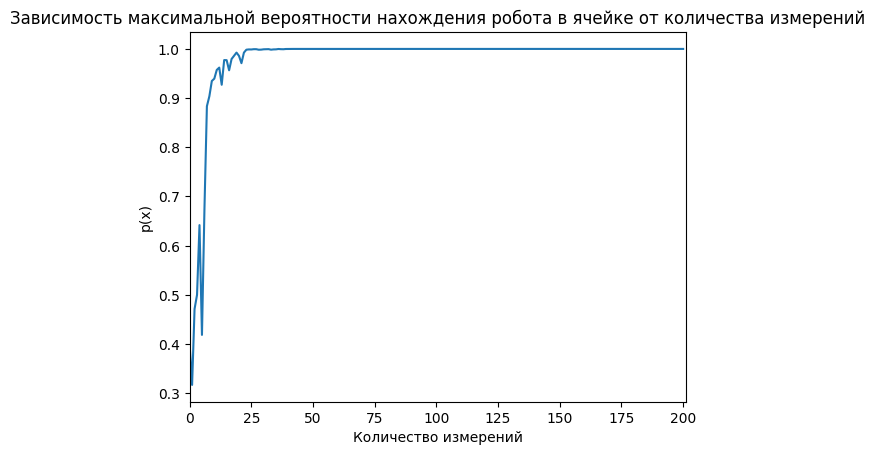

In [49]:
probability2 = []
for i in range(len(f_posteriors)):
  probability2.append(f_posteriors[i][real_position])

x = range(len(f_posteriors)) 

plt.plot(x, probability2)
plt.xlabel('Количество измерений')
plt.ylabel('p(x)')
plt.xlim(0, len(f_posteriors))
plt.title('Зависимость максимальной вероятности нахождения робота в ячейке от количества измерений')

## **Выводы**
При достаточно большом числе измерений можно добиться значения максимальной вероятности нахождения работа. Однако, если при этом значение квадратического отклонения относительно большое, то, в рамках задачи, даже 500 измерений может не хватить, чтобы обеспечить максимальную вероятность в районе 0.9

- Реализован метод, имитирующий перемещение робота в заданную ячейку с учетом неточности приводов
- Реализован метод, имитирующий работу датчика с заранее известным распределением ошибки
- Реализован метод для расчёта результата работы фильтра Баеса